<a href="https://colab.research.google.com/github/amirezzati/Arabic-Broken-Plural-RNN/blob/main/Arabic_broken_plurals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import string
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
dataPath="/content/drive/MyDrive/AI Projects/Arabic Broken Plural/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Preprocessing**

## **Get dataset files and Organizing**

In [ ]:
train_csv = pd.read_csv(dataPath+"/train_pairs_all.csv")
dev_csv = pd.read_csv(dataPath+"/dev_pairs_all.csv")
test_csv = pd.read_csv(dataPath+"/test_pairs_all.csv")

train_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,m,i,49,B,1a2a3,>a1o2A3,E.m.l,49
1,hadaf,>ahodAf,PL,m,i,42,B,1a2a3,>a1o2A3,h.d.f,42
2,EuDow,>aEoDA',PL,m,r,46,B,1u2ow,>a1o2A',E.D.#,39
3,jihAz,>ajohizap,PL,m,i,41,B,1i2A3,>a1o2i3ap,j.h.z,35
4,Hukom,>aHokAm,PL,m,i,35,B,1u2o3,>a1o2A3,H.k.m,35


In [ ]:
train_csv_filtered = train_csv[train_csv['ROOT'] != 'NTWS']
dev_csv_filtered = dev_csv[dev_csv['ROOT'] != 'NTWS']
test_csv_filtered = test_csv[test_csv['ROOT'] != 'NTWS']

In [ ]:
print(train_csv.shape[0] - train_csv_filtered.shape[0])
print(dev_csv.shape[0] - dev_csv_filtered.shape[0])
print(test_csv.shape[0] - test_csv_filtered.shape[0])

114
38
27


In [ ]:

# Label encoder for encoding gender and rational features
# 'B' class: 0      'S' class: 1
categorical_attr = ['GEN', 'RAT', 'B/S']

le = LabelEncoder()
#train_csv_filtered[categorical_attr] = train_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)
train_csv[categorical_attr] = train_csv[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
#dev_csv_filtered[categorical_attr] = dev_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)
dev_csv[categorical_attr] = dev_csv[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
#test_csv_filtered[categorical_attr] = test_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)
test_csv[categorical_attr] = test_csv[categorical_attr].apply(le.fit_transform, axis=0)

#test_csv_filtered.head()
test_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,1,0,23,0,1a2a3,>a1o2A3,E.m.l,23
1,hadaf,>ahodAf,PL,1,0,16,0,1a2a3,>a1o2A3,h.d.f,16
2,EalAqap,EalAqAt,PL,0,0,15,1,1a2A3ap,1a2A3At,E.l.q,15
3,mu&as~asap,mu&as~asAt,PL,0,0,14,1,mu&a2~a3ap,mu&a2~a3At,#.s.s,14
4,EuDow,>aEoDA',PL,1,1,15,0,1u2ow,>a1o2A',E.D.#,13


In [ ]:
def getListOfData(dataFrame):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:freq | 9:nmberOfRoot
  '''
  data = [] # 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
  data.append(dataFrame['lemma'].tolist())
  data.append(dataFrame['SING_PATT'].tolist())

  root = dataFrame['ROOT'].tolist()
  # delete dot sign(.) in root feature
  for i in range(len(root)): 
    root[i] = root[i].replace(".","")
    root[i] = root[i].replace("#","")
  data.append(root)

  data.append(dataFrame['inflection'].tolist())
  data.append(dataFrame['PL_PATT'].tolist())
  data.append(dataFrame['B/S'].tolist())
  data.append(dataFrame['GEN'].tolist())
  data.append(dataFrame['RAT'].tolist())
  data.append(dataFrame['FREQ'].tolist())

  numOfRoot = [len(x) for x in root]
  data.append(numOfRoot)

  return data

trainData = getListOfData(train_csv)
devData = getListOfData(dev_csv)
testData = getListOfData(test_csv)
is_dataOrginal=True

## **Analyzing Datasets**

In [ ]:
# generate samples of dev/test set which are not in train set
# compare with lemma
devSetExistence = np.array([lemma in trainData[0] for lemma in devData[0]])
testSetExistence = np.array([lemma in trainData[0] for lemma in testData[0]])

unseenLemmaIndices_dev = np.where(devSetExistence==False)[0]
unseenLemmaIndices_test = np.where(testSetExistence==False)[0]

print('number of unseen data(lemma) in dev set: ', np.count_nonzero(devSetExistence==False))
print('number of unseen data(lemma) in test set: ', np.count_nonzero(testSetExistence==False), end='\n\n')

# compare with (lemma, inflection) pair
  # first: generate (lemma, inflection) pair in sets
trainLemmaInf = np.stack((trainData[0], trainData[3]), axis=-1).tolist()
devLemmaInf = np.stack((devData[0], devData[3]), axis=-1).tolist()
testLemmaInf = np.stack((testData[0], testData[3]), axis=-1).tolist()

devSetExistence = np.array([lemInf in trainLemmaInf for lemInf in devLemmaInf])
testSetExistence = np.array([lemInf in trainLemmaInf for lemInf in testLemmaInf])

unseenLemInfIndices_dev = np.where(devSetExistence==False)[0]
unseenLemInfIndices_test = np.where(testSetExistence==False)[0]

print('number of unseen data((lemma, inflection) pair) in dev set: ', np.count_nonzero(devSetExistence==False))
print('number of unseen data((lemma, inflection) pair) in test set: ', np.count_nonzero(testSetExistence==False))

number of unseen data(lemma) in dev set:  85
number of unseen data(lemma) in test set:  78

number of unseen data((lemma, inflection) pair) in dev set:  108
number of unseen data((lemma, inflection) pair) in test set:  88


In [ ]:
# create dataframe for dev set's unseen data
    # 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
    
data_analysis_path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis/'
os.makedirs(data_analysis_path, exist_ok=True)  

unseenLemmaIndices_dev_df = pd.DataFrame({'index': unseenLemmaIndices_dev,
                                           'lemma': np.array(devData[0])[unseenLemmaIndices_dev],
                                           'inflection': np.array(devData[3])[unseenLemmaIndices_dev],
                                           'pl pattern': np.array(devData[4])[unseenLemmaIndices_dev]})
unseenLemmaIndices_dev_df.to_csv(data_analysis_path + 'unseenLemma_dev.csv')


unseenLemInfIndices_dev_df = pd.DataFrame({'index': unseenLemInfIndices_dev,
                                           'lemma': np.array(devData[0])[unseenLemInfIndices_dev],
                                           'inflection': np.array(devData[3])[unseenLemInfIndices_dev],
                                           'pl pattern': np.array(devData[4])[unseenLemInfIndices_dev]})
unseenLemInfIndices_dev_df.to_csv(data_analysis_path + 'unseenLemInf_dev.csv')

In [ ]:
unseenLemInfIndices_dev_df.head()

,index,lemma,inflection,pl pattern
0,224,muHaw~il,muHaw~ilAt,mu1aw~i3At
1,234,mujawohar,mujawoharAt,mu1awo3a4At
2,283,Haloy,Huliy~,1u2iy~
3,298,tAriyx,tawAriyx,tawA2iy3
4,325,$Aliyh,$AliyhAt,NTWSAt


In [ ]:
# create dataframe for test set's unseen data
unseenLemmaIndices_test_df = pd.DataFrame({'index': unseenLemmaIndices_test,
                                           'lemma': np.array(testData[0])[unseenLemmaIndices_test],
                                           'inflection': np.array(testData[3])[unseenLemmaIndices_test],
                                           'pl pattern': np.array(testData[4])[unseenLemmaIndices_test]})
unseenLemmaIndices_test_df.to_csv(data_analysis_path + 'unseenLemma_test.csv')


unseenLemInfIndices_test_df = pd.DataFrame({'index': unseenLemInfIndices_test,
                                           'lemma': np.array(testData[0])[unseenLemInfIndices_test],
                                           'inflection': np.array(testData[3])[unseenLemInfIndices_test],
                                           'pl pattern': np.array(testData[4])[unseenLemInfIndices_test]})
unseenLemInfIndices_test_df.to_csv(data_analysis_path + 'unseenLemInf_test.csv')

In [ ]:
unseenLemInfIndices_test_df.head()

,index,lemma,inflection,pl pattern
0,179,minaS~ap,minaS~At,mi1a2~At
1,274,muDorib,muDoribiyn,mu1o2i3iyn
2,312,Eubuw~ap,Eubuw~At,1u2uw~At
3,339,rafiyqap,rafiyqAt,1a2iy3At
4,362,sAEidap,sawAEid,1awA2i3


## **Work On Duplicates**

In [ ]:
# find duplicates and create dictionaries

def getDuplicateIndexes(data):
  dupindex={}
  f=False
  for i in range(len(data[0])):
    if f: break
    lemma = data[0][i]
    if dupindex.get(lemma)==None:
      dupindex[lemma]=[]
      dupindex[lemma].append(i)
    else:
      f=False
      for k in range(len(dupindex[lemma])):
        if data[8][i] > data[8][dupindex[lemma][k]]:
          dupindex[lemma].insert(0,i)
          f=True
      if not f : dupindex[lemma].append(i)


  return dupindex

def reportErrorAnalysis_duplicates(dataframe,dicDup,path):
  df=dataframe.loc[[]]
  
  indexes=[]
  for key, value in dicDup.items():
    if len(value)>1 :
      for x in value:
        n=len(df)
        indexes.append(x)
        df.loc[n]=dataframe.loc[x]
  df.insert(0, "index", indexes, True)
  df.to_csv(path)
  return df


if is_dataOrginal:
  #Save similar lemmas indexes in dictionary (key->lemma | value->list of indexes)
  trainDupIndex=getDuplicateIndexes(trainData)
  devDupIndex=getDuplicateIndexes(devData)
  testDupIndex=getDuplicateIndexes(testData)
  print("duplicate indexes has been updated")
  print(trainDupIndex)

if is_dataOrginal:
  #Save Duplicate report on data in csv
  trainDuplicateCsv=reportErrorAnalysis_duplicates(train_csv,trainDupIndex,data_analysis_path+"/duplicateAnalyssis_train.csv")
  devDuplicateCsv=reportErrorAnalysis_duplicates(dev_csv,devDupIndex,data_analysis_path+"/duplicateAnalyssis_dev.csv")
  testDuplicateCsv=reportErrorAnalysis_duplicates(test_csv,testDupIndex,data_analysis_path+"/duplicateAnalyssis_test.csv")
  print("Report Error Analysis on duplicates has been saved in /content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis path")

#Generate lemma-inflection refrence
dic_lemmaInflection={}
def updateDic_lemmaInflection(Data,dupIndex):
  global dic_lemmaInflection
  for key, value in dupIndex.items():
    if dic_lemmaInflection.get(key)==None:
      dic_lemmaInflection[key]=[]
    for x in value : 
      if not Data[3][x] in dic_lemmaInflection[key]: dic_lemmaInflection[key].append(Data[3][x])

if is_dataOrginal:
  updateDic_lemmaInflection(trainData,trainDupIndex)
  updateDic_lemmaInflection(testData,testDupIndex)
  updateDic_lemmaInflection(devData,devDupIndex)



duplicate indexes has been updated
{'Eamal': [0], 'hadaf': [1], 'EuDow': [2, 815, 1619], 'jihAz': [3, 689], 'Hukom': [4], 'EunoSur': [5], 'Haq~': [6], 'maSolaHap': [7], 'Eamaliy~ap': [8], 'farod': [9], 'siEor': [10], '<imokAn': [11], "<ijorA'": [12], 'mawoqif': [13], 'jahod': [14], 'quw~ap': [15, 292, 933, 1650, 1827, 1835, 1845], 'EalAqap': [16], 'sabab': [17], 'Sawot': [18], 'qarAr': [19], 'silAH': [20, 394], '>avar': [21], 'Tifol': [22], 'Hadav': [23], 'balad': [24, 102], 'natiyjap': [25], 'Zarof': [26], '{it~iSAl': [27], 'waDoE': [28], 'mu&as~asap': [29], 'TAlib': [30, 674, 1119, 1345, 2715, 2716], 'fikor': [31], 'niZAm': [32, 888, 1138], 'taSoriyH': [33, 1208], '>aroD': [34, 1204], 'tahodiyd': [35], 'dawolap': [36, 453], 'walad': [37], 'mAl': [38], 'baronAmaj': [39], 'yawom': [40], 'ma$oruwE': [41, 1375], 'Had~': [42], 'Taraf': [43], 'mAd~ap': [44], 'SAHib': [45, 2573], '{inotixAb': [46], '$aEob': [47], 'jaw~': [48, 2405], 'maTolab': [49], 'TA}irap': [50], 'HuDuwr': [51], 'minoTaq

In [ ]:
#Drop unnecessary duplicates
def getUniqueData(data,dupIndex):
  out=[]
  #init nested lists
  for x in data: out.append([])
  #fill out with most frequent lemma-inflection pairs
  for key, value in dupIndex.items():
    for k in range(len(data)):
      out[k].append(data[k][value[0]])
  return out


trainDataUnique=getUniqueData(trainData,trainDupIndex)
devDataUnique=getUniqueData(devData,devDupIndex)
testDataUnique=getUniqueData(testData,testDupIndex)
print("Number Of Lemmas before Dropping duplicates in Train Set: ", len(trainData[0]))
print("Number Of Lemmas before Dropping duplicates in Test Set: ",len(testData[0]))
print("Number Of Lemmas before Dropping duplicates in Dev Set: ",len(devData[0]))
print("=============================================================")
print("Number Of Lemmas After Dropping duplicates in Train Set: ", len(trainDataUnique[0]))
print("Number Of Lemmas After Dropping duplicates in Test Set: ",len(testDataUnique[0]))
print("Number Of Lemmas After Dropping duplicates in Dev Set: ",len(devDataUnique[0]))

Number Of Lemmas before Dropping duplicates in Train Set:  2862
Number Of Lemmas before Dropping duplicates in Test Set:  1103
Number Of Lemmas before Dropping duplicates in Dev Set:  1151
Number Of Lemmas After Dropping duplicates in Train Set:  2475
Number Of Lemmas After Dropping duplicates in Test Set:  1028
Number Of Lemmas After Dropping duplicates in Dev Set:  1060


In [ ]:
#######Risky Implementation!!! Only Run This Once
if is_dataOrginal:
  trainData=trainDataUnique
  devData=devDataUnique
  testData=testDataUnique
  is_dataOrginal=False
else:
  print("Warning!!! duplicate rows has already been dropped from data.(skipped this step)")

## **Encoding Datasets (Character-based)**

In [ ]:
# generate character encoding
oov_token = 'not available char'
char_index = {oov_token: 0}

def updateCharIndex(data):
  global char_index
  # encode input with encoding character set
  for i in range(len(data[0])):
      chars = data[0][i] + data[1][i] + data[3][i] + data[4][i]
      for c in chars:
          if c not in char_index:
              char_index[c] = len(char_index)

updateCharIndex(trainData)
print(len(char_index))
print(char_index)

50
{'not available char': 0, 'E': 1, 'a': 2, 'm': 3, 'l': 4, '1': 5, '2': 6, '3': 7, '>': 8, 'o': 9, 'A': 10, 'h': 11, 'd': 12, 'f': 13, 'u': 14, 'D': 15, 'w': 16, "'": 17, 'j': 18, 'i': 19, 'z': 20, 'p': 21, 'H': 22, 'k': 23, 'n': 24, 'S': 25, 'r': 26, '4': 27, 'q': 28, '~': 29, 'y': 30, 't': 31, 's': 32, '<': 33, 'b': 34, 'v': 35, '|': 36, 'T': 37, '}': 38, 'Z': 39, '{': 40, '&': 41, '$': 42, 'x': 43, 'N': 44, 'W': 45, '*': 46, 'g': 47, 'Y': 48, 'F': 49}


In [ ]:
# encode words with character encoder
def encodeWord(word, dic=char_index, oov=oov_token):
    return [dic[c] if c in dic else dic[oov] for c in list(word)]

# encode data and get maximum length of features
def getEncodedData(data):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
  '''

  data_encoded = data.copy()
  data_encoded[0] = [encodeWord(each) for each in data[0]]
  data_encoded[1] = [encodeWord(each) for each in data[1]]
  data_encoded[2] = [encodeWord(each) for each in data[2]]
  data_encoded[3] = [encodeWord(each) for each in data[3]]
  data_encoded[4] = [encodeWord(each) for each in data[4]]

  lemma_max_len = max([len(each) for each in data_encoded[0]])
  root_max_len = max([len(each) for each in data_encoded[2]])
  inflection_max_len = max([len(each) for each in data_encoded[3]])

  return data_encoded, lemma_max_len, root_max_len, inflection_max_len


trainData_encoded, lemma_max_len, root_max_len, inflection_max_len = getEncodedData(trainData)
devData_encoded, _, _, _  = getEncodedData(devData)
testData_encoded, _, _, _ = getEncodedData(testData)

print('lemma shape train: ', len(trainData_encoded[0]))
print('lemma shape dev: ', len(devData_encoded[0]))
print('lemma shape test: ', len(testData_encoded[0]))
print('max length in lemma elements: ', lemma_max_len)
print('max length in root elements: ', root_max_len)
print('max length in inflection elements: ', inflection_max_len)

lemma shape train:  2475
lemma shape dev:  1060
lemma shape test:  1028
max length in lemma elements:  17
max length in root elements:  4
max length in inflection elements:  18


In [ ]:
# ADD padding to sample
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
def getPaddedData(encodedData, lemma_max_len, root_max_len, inflection_max_len):
  data_pad = []
  data_pad.append(np.array(pad_sequences(encodedData[0], maxlen=lemma_max_len, padding='post'))) 
  data_pad.append(np.array(pad_sequences(encodedData[1], maxlen=lemma_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[2], maxlen=root_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[3], maxlen=inflection_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[4], maxlen=inflection_max_len, padding='post')))
  data_pad.append(np.array(encodedData[5]))
  data_pad.append(np.array(encodedData[6]))
  data_pad.append(np.array(encodedData[7]))
  data_pad.append(np.array(encodedData[8]))

  return data_pad

trainData_pad = getPaddedData(trainData_encoded, lemma_max_len, root_max_len, inflection_max_len)
devData_pad = getPaddedData(devData_encoded, lemma_max_len, root_max_len, inflection_max_len)
testData_pad = getPaddedData(testData_encoded, lemma_max_len, root_max_len, inflection_max_len)

print('lemma with pad shape train: ', trainData_pad[0].shape)
print('lemma with pad shape dev: ', devData_pad[0].shape)
print('lemma with pad shape test: ', testData_pad[0].shape)

lemma with pad shape train:  (2475, 17)
lemma with pad shape dev:  (1060, 17)
lemma with pad shape test:  (1028, 17)


### **Create inputs of neural network**

In [ ]:
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
# create train set
X_train_lemma = trainData_pad[0]  # lemma feature
X_train_singularPattern = trainData_pad[1]  # singular pattern feature
X_train_root = trainData_pad[2]  # root feature
X_train_genRat = np.stack((trainData_pad[6], trainData_pad[7]), axis=-1)  # gender & rational features
X_train_numOfRoot = trainData_pad[8].reshape((trainData_pad[8].shape[0], -1))  # number of root

y_train_class = trainData_pad[5].reshape((trainData_pad[5].shape[0], -1))  # broken or sound classes
y_train_plPattern = trainData_pad[4]  # plural pattern
y_train_inflection = trainData_pad[3]  # inflection

# create dev set
X_dev_lemma = devData_pad[0]  # lemma feature
X_dev_singularPattern = devData_pad[1]  # singular pattern feature
X_dev_root = devData_pad[2]  # root feature
X_dev_genRat = np.stack((devData_pad[6], devData_pad[7]), axis=-1)  # gender & rational features
X_dev_numOfRoot = devData_pad[8].reshape((devData_pad[8].shape[0], -1))  # number of root

y_dev_class = devData_pad[5].reshape((devData_pad[5].shape[0], -1))  # broken or sound classes
y_dev_plPattern = devData_pad[4]  # plural pattern
y_dev_inflection = devData_pad[3]  # inflection

# create test set
X_test_lemma = testData_pad[0]  # lemma feature
X_test_singularPattern = testData_pad[1]  # singular pattern feature
X_test_root = testData_pad[2]  # root feature
X_test_genRat = np.stack((testData_pad[6], testData_pad[7]), axis=-1)  # gender & rational features
X_test_numOfRoot = testData_pad[8].reshape((testData_pad[8].shape[0], -1))  # number of root

y_test_class = testData_pad[5].reshape((testData_pad[5].shape[0], -1))  # broken or sound classes
y_test_plPattern = testData_pad[4]  # plural pattern
y_test_inflection = testData_pad[3]  # inflection

print('X_train_lemma shape: ', X_train_lemma.shape)
print('X_train_singularPattern shape: ', X_train_singularPattern.shape)
print('X_train_root shape: ', X_train_root.shape)
print('X_train_genRat shape: ', X_train_genRat.shape)
print('X_train_numOfRoot shape: ', X_train_numOfRoot.shape)
print('y_train_class shape: ', y_train_class.shape)
print('y_train_plPattern shape: ', y_train_plPattern.shape)
print('y_train_unflection shape: ', y_train_inflection.shape)

X_train_lemma shape:  (2475, 17)
X_train_singularPattern shape:  (2475, 17)
X_train_root shape:  (2475, 4)
X_train_genRat shape:  (2475, 2)
X_train_numOfRoot shape:  (2475, 1)
y_train_class shape:  (2475, 1)
y_train_plPattern shape:  (2475, 18)
y_train_unflection shape:  (2475, 18)


In [ ]:
# Convert to ONE-HOT encoding
X_train_lemma_OH = to_categorical(X_train_lemma, len(char_index))
X_train_singularPattern_OH = to_categorical(X_train_singularPattern, len(char_index))
X_train_root_OH = to_categorical(X_train_root, len(char_index))

X_dev_lemma_OH = to_categorical(X_dev_lemma, len(char_index))
X_dev_singularPattern_OH = to_categorical(X_dev_singularPattern, len(char_index))
X_dev_root_OH = to_categorical(X_dev_root, len(char_index))

X_test_lemma_OH = to_categorical(X_test_lemma, len(char_index))
X_test_singularPattern_OH = to_categorical(X_test_singularPattern, len(char_index))
X_test_root_OH = to_categorical(X_test_root, len(char_index))

y_train_plPattern_OH = to_categorical(y_train_plPattern, len(char_index))
y_dev_plPattern_OH = to_categorical(y_dev_plPattern, len(char_index))
y_test_plPattern_OH = to_categorical(y_test_plPattern, len(char_index))

y_train_inflection_OH = to_categorical(y_train_inflection, len(char_index))
y_dev_inflection_OH = to_categorical(y_dev_inflection, len(char_index))
y_test_inflection_OH = to_categorical(y_test_inflection, len(char_index))

print(X_train_lemma_OH.shape)
print(X_train_singularPattern_OH.shape)
print(X_train_root_OH.shape)
print(y_train_plPattern_OH.shape)
print(y_train_inflection_OH.shape)

(2475, 17, 50)
(2475, 17, 50)
(2475, 4, 50)
(2475, 18, 50)
(2475, 18, 50)


In [ ]:
# covern numerical inputs to int32
X_train_genRat = np.asarray(X_train_genRat).astype('int32')
X_train_numOfRoot = np.asarray(X_train_numOfRoot).astype('int32')
X_dev_genRat = np.asarray(X_dev_genRat).astype('int32')
X_dev_numOfRoot = np.asarray(X_dev_numOfRoot).astype('int32')
X_test_genRat = np.asarray(X_test_genRat).astype('int32')
X_test_numOfRoot = np.asarray(X_test_numOfRoot).astype('int32')

y_train_class = np.asarray(y_train_class).astype('int32')
y_dev_class = np.asarray(y_dev_class).astype('int32')
y_test_class = np.asarray(y_test_class).astype('int32')

# **Helper Functions**

In [ ]:
def getDuplicateIndexes(data):
  dupindex={}
  for i in range(len(data[0])):
    if dupindex.get(data[0][i])==None:
      dupindex[data[0][i]]=[]
    dupindex[data[0][i]].append(i)

  return dupindex

def reportErrorAnalysis_duplicates(dataframe,dicDup,path):
  df=dataframe.loc[[]]
  
  indexes=[]
  for key, value in dicDup.items():
    for x in value:
      n=len(df)
      indexes.append(x)
      df.loc[n]=dataframe.loc[x]
  df.insert(0, "index", indexes, True)
  df.to_csv(path)
  return df


#Save similar lemmas indexes in dictionary (key->lemma | value->list of indexes)
trainDupIndex=getDuplicateIndexes(trainData)
devDupIndex=getDuplicateIndexes(devData)
testDupIndex=getDuplicateIndexes(testData)


#Save Duplicate report on data in csv
trainDuplicateCsv=reportErrorAnalysis_duplicates(train_csv,trainDupIndex,dataPath+"/duplicateAnalyssis_train.csv")
devDuplicateCsv=reportErrorAnalysis_duplicates(dev_csv,devDupIndex,dataPath+"/duplicateAnalyssis_dev.csv")
testDuplicateCsv=reportErrorAnalysis_duplicates(test_csv,testDupIndex,dataPath+"/duplicateAnalyssis_test.csv")

#Generate lemma-inflection refrence
dic_lemmaInflection={}
def updateDic_lemmaInflection(Data,dupIndex):
  global dic_lemmaInflection
  for key, value in dupIndex.items():
    if dic_lemmaInflection.get(key)==None:
      dic_lemmaInflection[key]=[]
      for x in value : 
        if not Data[3][x] in dic_lemmaInflection[key]: dic_lemmaInflection[key].append(Data[3][x])

updateDic_lemmaInflection(trainData,trainDupIndex)
updateDic_lemmaInflection(testData,testDupIndex)
updateDic_lemmaInflection(devData,devDupIndex)



In [ ]:
updateDic_lemmaInflection

<function __main__.updateDic_lemmaInflection(Data, dupIndex)>

In [ ]:
def oneHot2D(arr):
    tmp = np.zeros_like(arr)
    tmp[np.arange(len(arr)), arr.argmax(1)] = 1
    return tmp

def oneHot3D(arr):
    tmp = np.array([oneHot2D(x) for x in arr])
    return tmp

In [ ]:
char_index_key_list = list(char_index.keys())
char_index_val_list = list(char_index.values())
def getCharFromIdx(idx):
  position = char_index_val_list.index(idx)
  return char_index_key_list[position]

In [ ]:
def getWordFromOnehot(onehot):
  encoded=np.argmax(onehot,axis=1)
  word=[]
  for x in encoded :
    if x==0:break
    word.append(getCharFromIdx(x))
  return ''.join(word)

def binaryConversion(arr, threshold=0.5):
  tmp = np.zeros_like(arr)
  tmp[arr > threshold] = 1
  return tmp

def reportResult(model, history, X_test, y_test):

    # best models based on acc or loss in tarin set or test set
    testHistory = list(
        map(lambda x, y: [x, y], history['val_accuracy'], history['val_loss']))
    print(
        f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate test set = ", model.evaluate(X_test, y_test, verbose=0))

    y_test_pred = model.predict(X_test)
    y_test_pred = binaryConversion(y_test_pred)

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(y_test, y_test_pred))
    print(metrics.classification_report(y_test,
          y_test_pred, digits=3, target_names=['Broken', 'Sound']))
    
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

def checkAccuracy(pred, true):
  size = pred.shape[0]
  numOfTrue = 0
  for (x, y) in zip(pred, true):
    if np.array_equal(x, y):
      numOfTrue += 1
  
  return size-numOfTrue, numOfTrue/size

def checkAccuracy_anyAcceptableInflectionInDataset(lemma, pred, dic_refrence):
  size = pred.shape[0]
  numOfTrue = 0
  for i in range (len(pred)):
    w=getWordFromOnehot(pred[i])
    if w in dic_refrence[lemma[i]]:
      numOfTrue += 1
  
  return size-numOfTrue, numOfTrue/size

def reportErrorAnalysis(lemma, bs, pred_OH, inflection_OH, path):
  size = pred_OH.shape[0]
  report={'index':[], 'lemma':[], 'b/s':[], 'inflection':[], 'predict':[]}
  i=0
  for (x, y) in zip(pred_OH, inflection_OH):
    if not np.array_equal(x, y):
      report['index'].append(i)
      report['lemma'].append(lemma[i])
      report['b/s'].append(bs[i])
      report['inflection'].append(getWordFromOnehot(inflection_OH[i]))
      report['predict'].append(getWordFromOnehot(pred_OH[i]))
    i+=1
  
  df = pd.DataFrame(report) 
  df.to_csv(path)
  return df

In [ ]:
def reportPercentageOfBrokenSoundErrors(dataset_errorAnalysis):
  total_errors_num = dataset_errorAnalysis.shape[0]
  train_sound_error = np.sum(dataset_errorAnalysis['b/s'])
  train_broken_error = total_errors_num - train_sound_error
  return train_broken_error/total_errors_num * 100, train_sound_error/total_errors_num * 100

def reportPercentageOfUnseenErrors(errorIndices, unseenIndices):
  isInUnseen = np.array([index in unseenIndices for index in errorIndices])
  return np.count_nonzero(isInUnseen==True) / len(errorIndices) * 100, np.count_nonzero(isInUnseen==True) / len(unseenIndices) * 100

# **Classification Models**

In [ ]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Classification Models'

In [ ]:
lemma_length = X_train_lemma_OH.shape[1] #17
encode_size = X_train_lemma_OH.shape[2] #50
genRat_length = X_train_genRat.shape[1] #2

epochs = 100
batch_size = 64

## **Model 1**

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length,), name='Gender-Rational')


lstm = Bidirectional(LSTM(256, name='Lstm'), name='Bidirectional')(input_lemma)

c = Concatenate(axis=1, name='Concatenate')([lstm, input_genRat])

d = Dense(256, activation='relu', name='Dense1')(c)
d = Dense(64, activation='relu', name='Dense2')(d)
# d = Dense(32, activation='relu')(d)

output = Dense(1, activation='sigmoid', name='Class')(d)
model = Model(inputs=[input_lemma, input_genRat], outputs=output)

model.save(path + "/model 1/structure.h5")

checkpoint_filepath = path + '/model 1/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit([X_train_lemma_OH, X_train_genRat], y_train_class, batch_size=batch_size, epochs=epochs, 
                      verbose=1, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_class)).history

Epoch 1/100
39/39 [==============================] - 4s 35ms/step - loss: 0.5688 - accuracy: 0.7030 - val_loss: 0.4507 - val_accuracy: 0.7868
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 0.4602 - accuracy: 0.7681 - val_loss: 0.4350 - val_accuracy: 0.7783
Epoch 3/100
39/39 [==============================] - 0s 12ms/step - loss: 0.4289 - accuracy: 0.7814 - val_loss: 0.3930 - val_accuracy: 0.8104
Epoch 4/100
39/39 [==============================] - 1s 13ms/step - loss: 0.3971 - accuracy: 0.8053 - val_loss: 0.3601 - val_accuracy: 0.8217
Epoch 5/100
39/39 [==============================] - 0s 13ms/step - loss: 0.3812 - accuracy: 0.8198 - val_loss: 0.3560 - val_accuracy: 0.8302
Epoch 6/100
39/39 [==============================] - 1s 13ms/step - loss: 0.3507 - accuracy: 0.8376 - val_loss: 0.3254 - val_accuracy: 0.8443
Epoch 7/100
39/39 [==============================] - 1s 14ms/step - loss: 0.3262 - accuracy: 0.8525 - val_loss: 0.3029 - val_accuracy: 0.8623
Epoch 

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Lemma (InputLayer)             [(None, 17, 50)]     0           []                               
                                                                                                  
 Bidirectional (Bidirectional)  (None, 512)          628736      ['Lemma[0][0]']                  
                                                                                                  
 Gender-Rational (InputLayer)   [(None, 2)]          0           []                               
                                                                                                  
 Concatenate (Concatenate)      (None, 514)          0           ['Bidirectional[0][0]',          
                                                                  'Gender-Rational[0][0]'] 

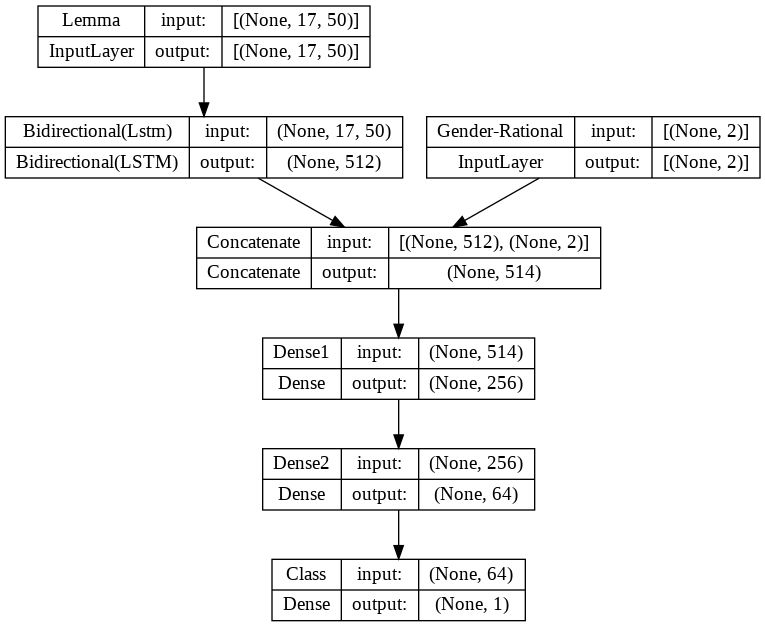

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_genRat], y_test_class)

33/33 [==============================] - 1s 5ms/step - loss: 0.1781 - accuracy: 0.9786


[0.1781269907951355, 0.9785992503166199]

In [ ]:
reportResult(model, history, [X_test_lemma_OH, X_test_genRat], y_test_class)

best model based on min test set loss:  acc= 0.9650943279266357  loss= 0.15437383949756622
best model based on max test set accuracy:  acc= 0.9754716753959656  loss= 0.25009629130363464

evaluate dataset with best model based on maximum test set accuracy
evaluate test set =  [0.1781269907951355, 0.9785992503166199]
33/33 [==============================] - 1s 4ms/step
------------------------------ metrics for test set ------------------------------
confusion matrix: 
 [[516  10]
 [ 12 490]]
              precision    recall  f1-score   support

      Broken      0.977     0.981     0.979       526
       Sound      0.980     0.976     0.978       502

    accuracy                          0.979      1028
   macro avg      0.979     0.979     0.979      1028
weighted avg      0.979     0.979     0.979      1028



# **Machine Translation Models**

In [ ]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Machine Translation Models'

In [ ]:
lemma_length = X_train_lemma_OH.shape[1] #17
singularPattern_length = X_train_singularPattern_OH.shape[1] #17
root_length = X_train_root_OH.shape[1] #4
genRat_length = X_train_genRat.shape[1] #2
numOfRoot_length = X_train_numOfRoot.shape[1] #1
plPattern_length = y_train_plPattern_OH.shape[1] #18
inflection_length = y_train_inflection_OH.shape[1] #18
encode_size = X_train_lemma_OH.shape[2] #50

epochs = 100
batch_size = 64

## **Model 1**
lemma - root - inflection

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_root = Input(shape=(root_length, encode_size), name='Root')
input_genRat = Input(shape=(genRat_length, ), name='Gender-Rational')


lstm1 = Bidirectional(LSTM(256, name='Lstm1'), name='Encoder')(input_lemma)
# lstm2 = Bidirectional(LSTM(64))(input_root)

# c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(254, activation='relu', name='Dense1')(lstm1)

c = Concatenate(axis=1, name='Concatenate')([d, input_genRat])

r = RepeatVector(inflection_length, name='RepeatVector')(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True, name='Lstm2'), name='Decoder')(r)

output = TimeDistributed(Dense(encode_size, activation='softmax', name='Dense2'), name='Inflection')(lstm2)

model1 = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 1/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model1.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model1.fit([X_train_lemma_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

Epoch 1/100
39/39 [==============================] - 8s 55ms/step - loss: 0.0514 - accuracy: 0.5616 - val_loss: 0.0403 - val_accuracy: 0.6044
Epoch 2/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0389 - accuracy: 0.6099 - val_loss: 0.0375 - val_accuracy: 0.6270
Epoch 3/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0371 - accuracy: 0.6282 - val_loss: 0.0356 - val_accuracy: 0.6465
Epoch 4/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0358 - accuracy: 0.6405 - val_loss: 0.0348 - val_accuracy: 0.6586
Epoch 5/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0345 - accuracy: 0.6545 - val_loss: 0.0339 - val_accuracy: 0.6557
Epoch 6/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0335 - accuracy: 0.6631 - val_loss: 0.0323 - val_accuracy: 0.6813
Epoch 7/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0321 - accuracy: 0.6772 - val_loss: 0.0308 - val_accuracy: 0.6939
Epoch 

In [ ]:
model1 = load_model(checkpoint_filepath)
model1.evaluate([X_test_lemma_OH, X_test_genRat], y_test_inflection_OH)

33/33 [==============================] - 3s 9ms/step - loss: 0.0031 - accuracy: 0.9843


[0.003147248877212405, 0.9843277335166931]

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Lemma (InputLayer)             [(None, 17, 50)]     0           []                               
                                                                                                  
 Encoder (Bidirectional)        (None, 512)          628736      ['Lemma[0][0]']                  
                                                                                                  
 Dense1 (Dense)                 (None, 254)          130302      ['Encoder[0][0]']                
                                                                                                  
 Gender-Rational (InputLayer)   [(None, 2)]          0           []                               
                                                                                            

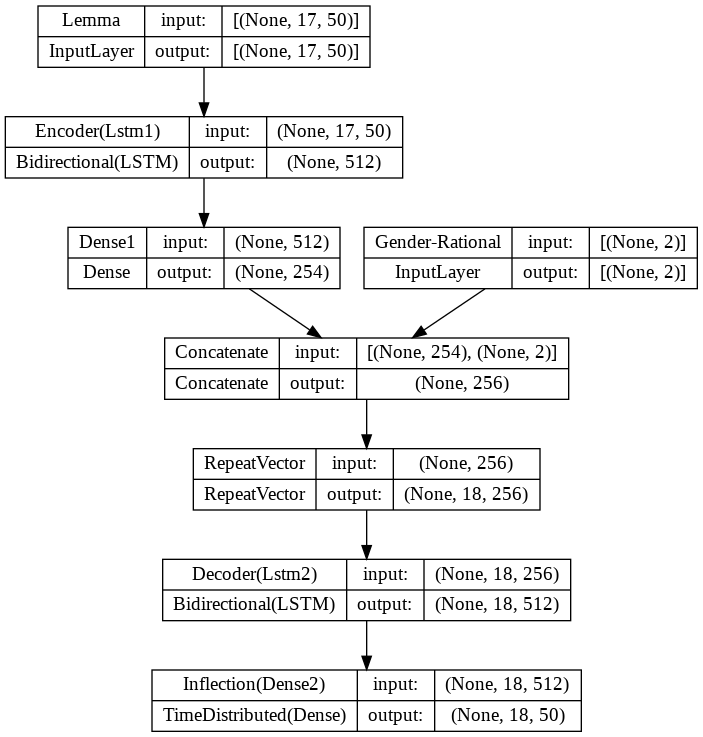

In [ ]:
print(model1.summary())
plot_model(model1, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=True)

### **Train analyze**

In [ ]:
train_pred = model1.predict([X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

78/78 [==============================] - 2s 5ms/step


(9, 0.9963636363636363)

In [ ]:
y_train_inflection_OH.shape

(2475, 18, 50)

In [ ]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, path + "/model 1/train_errorAnalysis.csv")
train_errorAnalysis.head()

,index,lemma,b/s,inflection,predict
0,40,yawom,0,>ay~Am,>ay~AA
1,863,tilofizyuwn,1,tilofizyuwnAt,tilofizzuwnAt
2,939,fiyliyb~iyniy~,1,fiyliyb~iyniy~iyn,fiyliyb~~yiy~iyn
3,948,briyTAniy~,1,briyTAniy~iyn,bryyTAniy~iyn
4,1045,<isotuwdiyuw,1,<isotuwdiyuwAt,<isotuwdiyuwAAt


In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

(Broken error %, Sound error %):  (22.22222222222222, 77.77777777777779)


In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0],train_pred_OH,dic_lemmaInflection)

(9, 0.9963636363636363)

### **Dev analyze**

In [ ]:
dev_pred = model1.predict([X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

34/34 [==============================] - 0s 5ms/step


(95, 0.910377358490566)

In [ ]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5], dev_pred_OH, y_dev_inflection_OH, path + "/model 1/dev_errorAnalysis.csv")
dev_errorAnalysis.head()

,index,lemma,b/s,inflection,predict
0,56,yawom,0,>ay~Am,>ay~AA
1,59,nAdiy,0,>anodiyap,nawAdiy
2,193,>amoriykiy~,1,>amoriykiy~iyn,>amiyrokiy~iyn
3,213,na$AT,0,>ano$iTap,na$ATAt
4,229,mujawohar,1,mujawoharAt,mujahararAt


In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

(Broken error %, Sound error %):  (53.68421052631579, 46.31578947368421)


In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0],dev_pred_OH,dic_lemmaInflection)

(70, 0.9339622641509434)

In [ ]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = dev_errorAnalysis['index'].tolist()
unseenIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(17.894736842105264, 15.74074074074074)


### **Test analyze**

In [ ]:
test_pred = model1.predict([X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

33/33 [==============================] - 0s 5ms/step


(85, 0.9173151750972762)

In [ ]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, path + "/model 1/test_errorAnalysis.csv")

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

(Broken error %, Sound error %):  (51.76470588235295, 48.23529411764706)


In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0],test_pred_OH,dic_lemmaInflection)

(66, 0.9357976653696498)

In [ ]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(14.117647058823529, 13.636363636363635)


## **Model 2**
lemma - inflection

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_sinPat = Input(shape=(singularPattern_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))
input_numOfRoot = Input(shape=(numOfRoot_length, ))


lstm1 = Bidirectional(LSTM(256))(input_lemma)
lstm2 = Bidirectional(LSTM(128))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(1000, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(inflection_length)(c)

lstm = Bidirectional(LSTM(256, return_sequences=True))(r)

# dense = TimeDistributed(Dense(128, activation='relu'))(lstm)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm)

model1 = Model(inputs=[input_lemma, input_sinPat, input_root, input_genRat, input_numOfRoot], outputs=output)

checkpoint_filepath = path + '/model 2/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model1.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model1.fit([X_train_lemma_OH, X_train_singularPattern_OH, X_train_root_OH, X_train_genRat, X_train_numOfRoot], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_singularPattern_OH, X_dev_root_OH, X_dev_genRat, X_dev_numOfRoot], y_dev_inflection_OH))  # starts training

In [ ]:
print(model1.summary())
plot_model(model1, to_file=path+'/model 2/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_singularPattern_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot], y_test_inflection_OH)

In [ ]:
pred_plPattern = model.predict([X_test_lemma_OH, X_test_singularPattern_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot])

pred_plPattern = oneHot3D(pred_plPattern)

print(pred_plPattern.shape)
print(y_test_plPattern_OH.shape)

34/34 [==============================] - 4s 15ms/step
(1076, 17, 48)
(1076, 17, 48)


In [ ]:
reportErrorAnalysis(testData[0],pred_plPattern,y_test_inflection_OH, path+"/model 2/test_errorAnalysis.csv")

,index,lemma,inflection,predict
0,7,quw~ap,quw~At,quwaY
1,17,balad,bilAd,bilAd
2,41,maso&uwl,maso&uwliyn,maso}uwliyn
3,65,mu$okilap,ma$Akil,mu$okilA
4,69,TAlib,Tul~Ab,TAlibb
...,...,...,...,...
132,1056,majoraY,mujorayAt,majoray
133,1060,mano$uwr,mano$uwrAt,manA$iyr
134,1061,manobat,manAbit,manAtib
135,1065,maqAm,maqAmAt,maqAmim


In [ ]:
checkAccuracy(pred_plPattern, y_test_inflection_OH)

(137, 0.8726765799256505)

## **Model 3**
singular pattern - plural pattern

In [ ]:
input_singularPattern = Input(shape=(singularPattern_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_singularPattern)
lstm2 = Bidirectional(LSTM(64))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(126, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(plPattern_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model2 = Model(inputs=[input_singularPattern, input_root, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 2/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model2.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model2.fit([X_train_singularPattern_OH, X_train_root_OH, X_train_genRat], y_train_plPattern_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_singularPattern_OH, X_dev_root_OH, X_dev_genRat], y_dev_plPattern_OH))  # starts training

In [ ]:
print(model2.summary())
plot_model(model2, to_file=path+'/model 2/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_singularPattern_OH, X_test_root_OH, X_test_genRat], y_test_plPattern_OH)

35/35 [==============================] - 2s 8ms/step - loss: 0.0032 - accuracy: 0.9736


[0.0032125026918947697, 0.9735569953918457]

## **Model 4**
lemma - plural pattern

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))
input_numOfRoot = Input(shape=(numOfRoot_length, ))


lstm1 = Bidirectional(LSTM(128))(input_lemma)
lstm2 = Bidirectional(LSTM(128))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(254, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(plPattern_length)(c)

lstm1 = Bidirectional(LSTM(128, return_sequences=True))(r)
# lstm2 = Bidirectional(LSTM(256, return_sequences=True))(lstm1)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm1)

model3 = Model(inputs=[input_lemma, input_root, input_genRat, input_numOfRoot], outputs=output)

checkpoint_filepath = path + '/model 3/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model3.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model3.fit([X_train_lemma_OH, X_train_root_OH, X_train_genRat, X_train_numOfRoot], y_train_plPattern_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_root_OH, X_dev_genRat, X_dev_numOfRoot], y_dev_plPattern_OH))  # starts training

In [ ]:
print(model3.summary())
plot_model(model3, to_file=path+'/model 3/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot], y_test_plPattern_OH)

34/34 [==============================] - 2s 7ms/step - loss: 0.0973 - accuracy: 0.9712


[0.09726995974779129, 0.9711896181106567]

In [ ]:
pred_plPattern = model.predict([X_test_lemma_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot])

print(pred_plPattern.shape)
print(y_test_plPattern_OH.shape)

34/34 [==============================] - 2s 6ms/step
(1076, 17, 48)
(1076, 17, 48)


In [ ]:
reportErrorAnalysis(testData[0],pred_plPattern,y_test_inflection_OH, path+"/model 3/test_errorAnalysis.csv")

In [ ]:
pred_plPattern = oneHot3D(pred_plPattern)

In [ ]:
checkAccuracy(pred_plPattern, y_test_plPattern_OH)

0.7955390334572491

## **Model 5**
lemma - inflection

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_lemma)

d = Dense(254, activation='relu')(lstm1)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(inflection_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model5 = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 5/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model5.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model5.fit([X_train_lemma_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

Epoch 1/100
45/45 [==============================] - 8s 63ms/step - loss: 0.0501 - accuracy: 0.5612 - val_loss: 0.0391 - val_accuracy: 0.6090
Epoch 2/100
45/45 [==============================] - 1s 19ms/step - loss: 0.0388 - accuracy: 0.6127 - val_loss: 0.0371 - val_accuracy: 0.6228
Epoch 3/100
45/45 [==============================] - 1s 18ms/step - loss: 0.0370 - accuracy: 0.6282 - val_loss: 0.0353 - val_accuracy: 0.6396
Epoch 4/100
45/45 [==============================] - 1s 18ms/step - loss: 0.0353 - accuracy: 0.6453 - val_loss: 0.0338 - val_accuracy: 0.6523
Epoch 5/100
45/45 [==============================] - 1s 18ms/step - loss: 0.0339 - accuracy: 0.6580 - val_loss: 0.0329 - val_accuracy: 0.6750
Epoch 6/100
45/45 [==============================] - 1s 18ms/step - loss: 0.0326 - accuracy: 0.6739 - val_loss: 0.0309 - val_accuracy: 0.6917
Epoch 7/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0309 - accuracy: 0.6888 - val_loss: 0.0292 - val_accuracy: 0.7077
Epoch 

In [ ]:
model5 = load_model(checkpoint_filepath)
model5.evaluate([X_test_lemma_OH, X_test_genRat], y_test_inflection_OH)

35/35 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9775


[0.0027498039416968822, 0.9774856567382812]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 17, 50)]     0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 512)         628736      ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 dense_5 (Dense)                (None, 254)          130302      ['bidirectional_4[0][0]']        
                                                                                                  
 input_7 (InputLayer)           [(None, 2)]          0           []                         

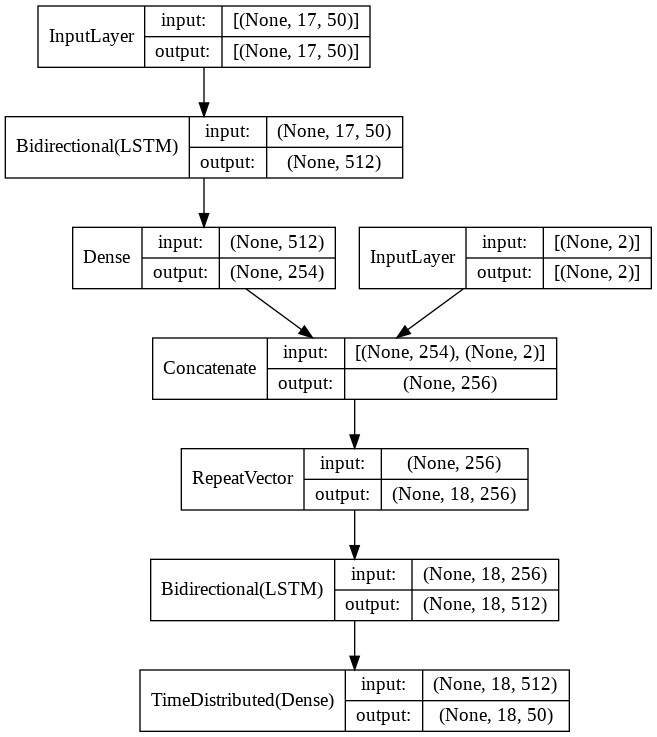

In [ ]:
print(model5.summary())
plot_model(model5, to_file=path+'/model 5/architecture.png', show_shapes=True, show_layer_names=False)

### **Train analyze**

In [ ]:
train_pred = model5.predict([X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

90/90 [==============================] - 2s 6ms/step


(209, 0.926974143955276)

In [ ]:
y_train_inflection_OH.shape

(2862, 18, 50)

In [ ]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, path + "/model 5/train_errorAnalysis.csv")
train_errorAnalysis.head()

,index,lemma,b/s,inflection,predict
0,15,quw~ap,1,quw~At,quwaY
1,24,balad,0,bilAd,bulAdAn
2,30,TAlib,0,Tul~Ab,Talabap
3,32,niZAm,0,>anoZimap,>aZuZi
4,33,taSoriyH,1,taSoriyHAt,taSAriyHA


In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

(Broken error %, Sound error %):  (65.55023923444976, 34.44976076555024)


In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0],train_pred_OH,dic_lemmaInflection)

(142, 0.9503843466107617)

### **Dev analyze**

In [ ]:
dev_pred = model5.predict([X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

36/36 [==============================] - 0s 5ms/step


(176, 0.8470894874022589)

In [ ]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5], dev_pred_OH, y_dev_inflection_OH, path + "/model 5/dev_errorAnalysis.csv")
dev_errorAnalysis.head()

,index,lemma,b/s,inflection,predict
0,13,>ax,0,<ixowAn,<ixowAp
1,14,TAlib,0,Tul~Ab,Talabap
2,17,>amor,0,>umuwr,>umAmrr
3,24,balad,0,bilAd,bulAdAn
4,26,quw~ap,1,quw~At,quwaY


In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

(Broken error %, Sound error %):  (58.52272727272727, 41.47727272727273)


In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0],dev_pred_OH,dic_lemmaInflection)

(135, 0.8827106863596872)

In [ ]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()
unseenIndices_dev = dev_errorAnalysis['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(85.18518518518519, 52.27272727272727)


### **Test analyze**

In [ ]:
test_pred = model5.predict([X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

35/35 [==============================] - 0s 5ms/step


(144, 0.8694469628286491)

In [ ]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, path + "/model 5/test_errorAnalysis.csv")

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

(Broken error %, Sound error %):  (58.333333333333336, 41.66666666666667)


In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0],test_pred_OH,dic_lemmaInflection)

(117, 0.8939256572982774)

In [ ]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = unseenLemInfIndices_test_df['index'].tolist()
unseenIndices_test = test_errorAnalysis['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(69.31818181818183, 42.36111111111111)


## **Mix Model (2 Networks: Classification + Machine Translation)**

In [ ]:
BSClassification_path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Classification Models'
BSClassification_model_path = BSClassification_path + '/model 1/weights.hdf5'
BSClassification_model_structure_path = BSClassification_path + "/model 1/structure.h5"

BSC_model = load_model(BSClassification_model_path)
BSC_model_struct = load_model(BSClassification_model_structure_path)

BSC_model_struct.set_weights(BSC_model.get_weights())
BSC_model_struct.trainable = False
# print(BSC_model.layers[1].get_weights()[0][0])
print(BSC_model_struct.layers[1].get_weights()[0][0])

OSError: ignored

In [ ]:
# print(y_train_class[0:10])
BSC_model_struct.predict([X_train_lemma_OH, X_train_genRat])[0:10]

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size), name='Lemma')
input_genRat = Input(shape=(genRat_length, ), name='Gender-Rational')

cls = BSC_model_struct([input_lemma, input_genRat])

lstm1 = Bidirectional(LSTM(256, name='Lstm1'), name='Encoder')(input_lemma)

d = Dense(252, activation='relu', name='Dense1')(lstm1)

c = Concatenate(axis=1, name='Concatenate')([d, input_genRat, cls, cls])

r = RepeatVector(inflection_length, name='RepeatVector')(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True, name='Lstm2'), name='Decoder')(r)

output = TimeDistributed(Dense(encode_size, activation='softmax', name='Dense2'), name='Inflection')(lstm2)

mix_model = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = path + '/Mix Model/weights.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

mix_model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
mix_model.layers[4].layers[1].get_weights()[0][0]

In [ ]:
with tf.device('/GPU:0'):
  mix_model.fit([X_train_lemma_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

In [ ]:
mix_model = load_model(checkpoint_filepath)
mix_model.evaluate([X_test_lemma_OH, X_test_genRat], y_test_inflection_OH)

In [ ]:
print(mix_model.summary())
# os.makedirs(path+'/Mix Model', exist_ok=True)
plot_model(mix_model, to_file=path+'/Mix Model/architecture.png', show_shapes=True, show_layer_names=True)

### **Train analyze**

In [ ]:
train_pred = mix_model.predict([X_train_lemma_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

In [ ]:
y_train_inflection_OH.shape

In [ ]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, path + "/Mix Model/train_errorAnalysis.csv")
train_errorAnalysis.head()

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(trainData[0],train_pred_OH,dic_lemmaInflection)

### **Dev analyze**

In [ ]:
dev_pred = mix_model.predict([X_dev_lemma_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

In [ ]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5], dev_pred_OH, y_dev_inflection_OH, path + "/Mix Model/dev_errorAnalysis.csv")
dev_errorAnalysis.head()

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(devData[0], dev_pred_OH, dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = dev_errorAnalysis['index'].tolist()
unseenIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

### **Test analyze**

In [ ]:
test_pred = mix_model.predict([X_test_lemma_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

In [ ]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, path + "/Mix Model/test_errorAnalysis.csv")

In [ ]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

In [ ]:
checkAccuracy_anyAcceptableInflectionInDataset(testData[0], test_pred_OH, dic_lemmaInflection)

In [ ]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = test_errorAnalysis['index'].tolist()
unseenIndices_test = unseenLemInfIndices_test_df['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))